In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from collections import  Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import psutil

import plotly.express as px

os.chdir('H:\\all\\RL_Shrinkage_2024')
from helpers import rl_covmat_ests_for_dataset as estimators
from helpers import helper_functions as hf
from helpers import eval_funcs_multi_target
from helpers import eval_funcs
from helpers import eval_function_new
import helpers_linear_shrinkage as hf_ls
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from sklearn.preprocessing import StandardScaler, Normalizer


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\traitlets\con

In [2]:
def myplot(*args):
    fig = plt.figure()
    ax = plt.axes()
    x = args[0].index
    for arg in args:
        ax.plot(x, arg)
    plt.legend()
    plt.show()

In [3]:
from sklearn.linear_model import ElasticNet
def general_single_output_ElasticNet_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None, params={}):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = ElasticNet(random_state=123, **params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = ElasticNet(random_state=123, **params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = (np.round(preds, 0))

            if i%50==1:
                print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [4]:
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8,9])

In [5]:
base_folder_path = r'H:\\all\\RL_Shrinkage_2024'

# IMPORT SHRK DATASETS
shrk_data_path = None
PF_SIZE = 500

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{PF_SIZE}\fixed_shrkges_cov2Para_p{PF_SIZE}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{PF_SIZE}\cov2Para_factor-1.0_p{PF_SIZE}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{PF_SIZE}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{PF_SIZE}.pickle")


In [6]:
fixed_shrk_data

,date,hist_vola,0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0
1,19810112,0,0.287782,0.084439,0.082245,0.080263,0.078459,0.076806,0.075282,0.07387,...,0.058866,0.060497,0.062489,0.064979,0.068178,0.072442,0.078405,0.087311,0.101935,0.129775
2,19810113,0,8.211038,0.079946,0.077936,0.076123,0.074476,0.072967,0.071577,0.07029,...,0.05748,0.059143,0.061178,0.063725,0.067001,0.071369,0.077471,0.086571,0.101474,0.129759
3,19810114,0,1.148828,0.083465,0.08129,0.079337,0.077568,0.075953,0.074468,0.073096,...,0.05592,0.057509,0.059483,0.061989,0.065256,0.069666,0.075898,0.085278,0.100751,0.130282
4,19810115,0,0.901553,0.081032,0.079038,0.077243,0.075614,0.074123,0.072749,0.071476,...,0.055815,0.057427,0.059426,0.061961,0.06526,0.069707,0.075977,0.085393,0.100889,0.130407
5,19810116,0,2.169634,0.084643,0.082731,0.080994,0.079405,0.077943,0.076589,0.07533,...,0.058355,0.059946,0.061924,0.06443,0.067689,0.072069,0.078221,0.087402,0.102381,0.130581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10349,20220125,0,7.573579,0.128194,0.126459,0.124979,0.123689,0.122544,0.121517,0.120586,...,0.13283,0.134924,0.137392,0.140362,0.144039,0.148766,0.155182,0.164655,0.180826,0.218135
10350,20220126,0,1.739916,0.125276,0.122898,0.1209,0.119189,0.117699,0.116387,0.115221,...,0.128505,0.130676,0.133244,0.136353,0.140229,0.145255,0.152145,0.162414,0.180051,0.220522
10351,20220127,0,1.453516,0.126657,0.124963,0.123566,0.12239,0.121386,0.120521,0.119768,...,0.148123,0.150511,0.153288,0.156588,0.16062,0.165732,0.17257,0.182502,0.199146,0.236834
10352,20220128,0,0.666386,0.122873,0.120408,0.118397,0.116722,0.115308,0.114102,0.113066,...,0.146824,0.149359,0.152291,0.15575,0.159942,0.165206,0.172162,0.182115,0.198491,0.234909


In [7]:
# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

In [8]:
cvc_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]


In [9]:
optimal_shrk_data["shrk_factor"]*100

1        18.874675
2        18.771204
3        18.645676
4        18.561109
5        18.625705
           ...    
10349     9.958382
10350     9.831225
10351     9.665234
10352     9.610265
10353     9.472902
Name: shrk_factor, Length: 10353, dtype: object

In [53]:
f = 0.5
ynew = (f * optimal_shrk_data["shrk_factor"] + (1-f)*all_res.idxmin(axis=1).values.astype(float)).copy().astype(float)

ynew.round(2)
Y = (f * optimal_shrk_data["shrk_factor"] + (1-f)*all_res.idxmin(axis=1).values.astype(float)).astype(float).values.round(2)


array([0.42, 0.42, 0.44, ..., 0.18, 0.16, 0.19])

In [54]:

all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
#all_res = all_res.iloc[:, list(range(0,101,5))]  # --> fewer values to predict, didn't work out though
  
all_factors = all_res.columns.astype(float).values
Y = (all_res.idxmin(axis=1).values.astype(float) + optimal_shrk_data["shrk_factor"])
Y = (f * optimal_shrk_data["shrk_factor"] + (1-f)*all_res.idxmin(axis=1).values.astype(float)).astype(float).values.round(2)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))


#Y =  (pd.Series(Y).rolling(window=60, min_periods=1).mean().values - (optimal_shrk_data["shrk_factor"]*100).rolling(window=60, min_periods=1).mean().values.astype(int)) / pd.Series(Y).rolling(window=60, min_periods=1).std().values
#Y[Y==np.inf] = Y[2]
#Y[np.isnan(Y)] = Y[2]
#Y = Y + optimal_shrk_data["shrk_factor"].values*100
#Y = np.clip(Y, 0, 100)

#Y = optimal_shrk_data["shrk_factor"].values * 100 * (1 +  pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values / 100 ) - optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values



opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values

rolling_opt3 = optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values



#sr = rolling_opt / rolling_opt3
#opt_v5 = opt_values - rolling_opt


#rolling_opt3 = pd.Series(opt_values).rolling(window=90, min_periods=1).std().fillna(0).values
#rolling_opt4 = pd.Series(opt_v3).rolling(window=90, min_periods=1).std().fillna(0).values


H:\all\RL_Shrinkage_2024\helpers\eval_function_new.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


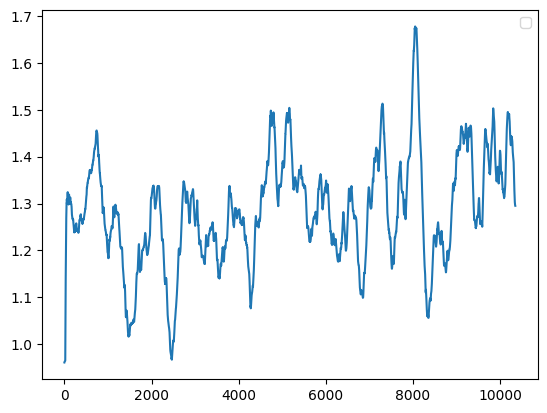

In [11]:
eval_function_new.myplot((1 +  pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values / 100 ) - optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


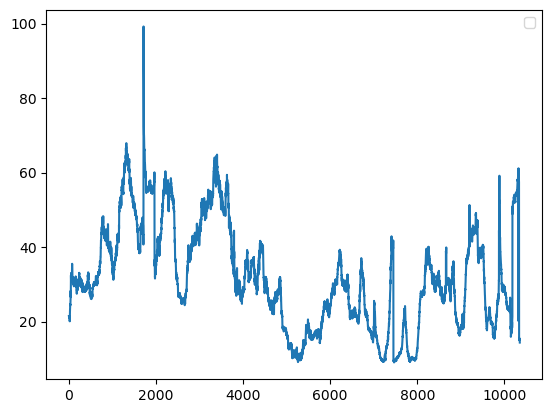

In [103]:
eval_function_new.myplot(optimal_shrk_data["shrk_factor"].values * 100 * (1 +  pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values / 100 ) - optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


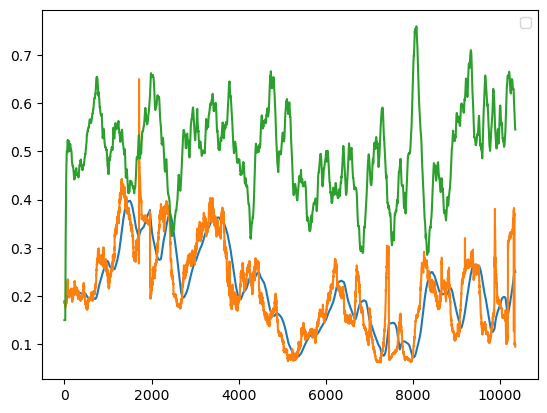

In [86]:
eval_function_new.myplot(optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values,
                         optimal_shrk_data["shrk_factor"].values,
                         pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values / 100
                        
                        optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values * ()
                        )

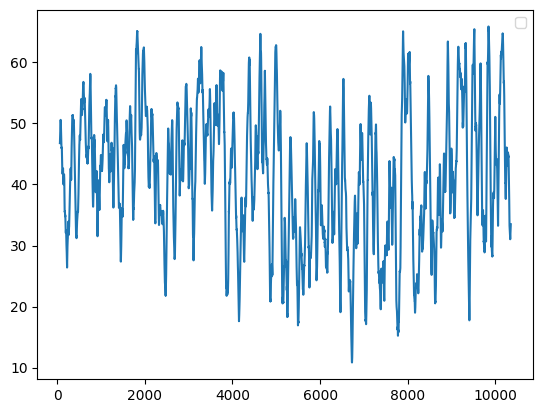

In [80]:
eval_function_new.myplot(pd.Series(y_lagged).rolling(63).mean())

In [67]:
y_lagged = (f * optimal_shrk_data["shrk_factor"] + (1-f)*all_res.idxmin(axis=1).values.astype(float)).astype(float).values.round(2)
y_lagged = np.insert(y_lagged, 0, np.repeat(0.35, 21))[:-21]
y_lagged = y_lagged * 100

In [73]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
#all_res = all_res.iloc[:, list(range(0,101,5))]  # --> fewer values to predict, didn't work out though
  
all_factors = all_res.columns.astype(float).values
Y = (all_res.idxmin(axis=1).values.astype(float) + optimal_shrk_data["shrk_factor"])
f = 0.3
Y = (f * optimal_shrk_data["shrk_factor"] + (1-f)*all_res.idxmin(axis=1).values.astype(float)).astype(float).values.round(2)

y_lagged = (f * optimal_shrk_data["shrk_factor"] + (1-f)*all_res.idxmin(axis=1).values.astype(float)).astype(float).values.round(2)
y_lagged = np.insert(y_lagged, 0, np.repeat(0.35, 21))[:-21]
y_lagged = y_lagged * 100

opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))

opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values

rolling_opt3 = optimal_shrk_data["shrk_factor"].rolling(window=252, min_periods=1).mean().values

params = {
'pf_size' : PF_SIZE,
'opt_values_factors' : rolling_opt,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': False,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
'additional_inputs' : [opt_v3, rolling_opt2, y_lagged]
#[rolling_opt2, rolling_opt, rolling_opt3]
}



X = re_hf.load_additional_train_data(**params)

In [74]:
"""res = general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040, 
                                              params={"l1_ratio":0.5, "max_iter":5000, "alpha":10, "tol": 1e9}
                                             )"""

res = general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040)

res[res<0]=0
res[res>100]=100
mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)


EVAL = False
if EVAL == True:
    r = eval_function_new.eval_fct_networkonly_1YR(Y[5040:]/100, rets_full, permnos, 0, val_indices_results)
    print(r)

fitted model in iteration 1 out of 253
fitted model in iteration 51 out of 253
fitted model in iteration 101 out of 253
fitted model in iteration 151 out of 253
fitted model in iteration 201 out of 253
fitted model in iteration 251 out of 253


C:\Users\dkostovic\AppData\Local\Temp\6\ipykernel_48476\2324211842.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


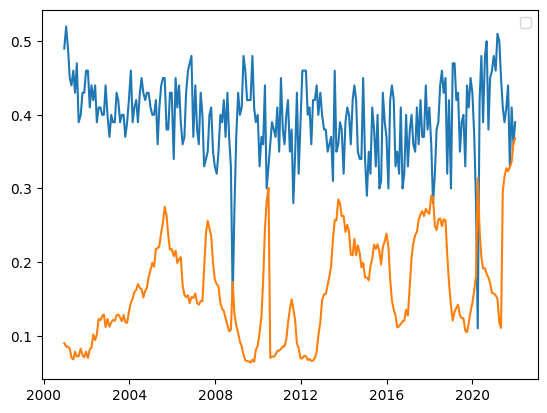

In [75]:
CVC_RL = pd.DataFrame(mapped_res[val_idxes_shrkges], 
                      index = pd.to_datetime(permnos.index[val_indices_results], format="%Y%m%d"), columns=["CVC-RL"])
CVC = pd.DataFrame(cvc_shrk[val_idxes_shrkges], index = pd.to_datetime(permnos.index[val_indices_results], format="%Y%m%d"),
                   columns=["CVC"])

#Y =  pd.Series(Y).rolling(window=60, min_periods=1).mean().values / pd.Series(Y).rolling(window=60, min_periods=1).std().values


myplot(CVC_RL, CVC)

#myplot(CVC_RL, CVC, X[val_idxes_shrkges, 3])

In [24]:
r = eval_function_new.eval_fct_networkonly_1YR(optimal_shrk_data["shrk_factor"].values[5040:], rets_full, permnos, 0, val_indices_results)

In [110]:
import seaborn as sns

In [113]:
for i, column in enumerate(X.columns, 1):
    plt.subplot(3,3,i)
    sns.histplot(X[column])

AttributeError: 'numpy.ndarray' object has no attribute 'columns'